## QOSF Mentorship Task 1
***
Hi, my name is Arush Tagade, I'll be attempting Task 1 as a screening task. Please move to the last cell for the final code and analysis. If you would like an insight in my thought process, please continue from the next cell. 
***

The first step was to create the circuit according to the given scenario, I used Qiskit for this as I had prior experience with it and now after experimenting with Pennylane for the past two days, I can say that it has a better circuit drawing tool.

The circuit has 4 qubits and two repeating blocks of operations that are parametrized by 'theta' and this lead to the simple circuit code in the following cell. I understand that I could define the blocks as two composite gates, in a more complex scenario this would be the technique I would opt for. The following code also demonstrates the circuit with different layers by modifying the variable L.


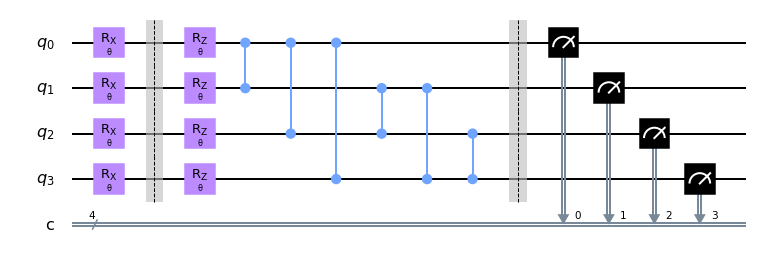

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit import QuantumRegister

L = 1
theta = Parameter('θ')
angle = np.random.randint(0,2*np.pi, size = 1)
qc = QuantumCircuit(4,4)

for l in range(L):
    qc.rx(theta, range(4))
    qc.barrier()

    qc.rz(theta, range(4))
    qc.cz(0,1)
    qc.cz(0,2)
    qc.cz(0,3)
    qc.cz(1,2)
    qc.cz(1,3)
    qc.cz(2,3)
    qc.barrier()

qc.measure([0,1,2,3],[0,1,2,3])
qc.draw('mpl')

### Randomness

The optimization process is supposed to start from a random initial point and use a random vector for cost function calculation. The variables angle and rand_vec are created to capture these requirements.

In [4]:
import numpy as np
import random

angle = [random.uniform(0,2*np.pi)]
rand_vec = [np.random.randint(0,2) for i in range(4)]
rand = str(rand_vec[0])+str(rand_vec[1])+str(rand_vec[2])+str(rand_vec[3]) #this conversion is necessary for a comparison later
print(rand_vec, angle)

[1, 1, 0, 0] [4.929205237040756]


### Cost Function

Now the cost function needs to be defined using the random vector and output vector of the circuit. For this I used the qasm simulator, I understand this brings noise to the process and I used this in the hope of a more realistic simulation. Now the cost function is defined as 
                                                $$\epsilon = ||  |\Psi(\theta)> - |\phi> ||$$
where |$\phi$> is the random vector and the || || operation is the sum of squares of the components of the enclosed vector.

The output vector is given by, 
                   $$|\Psi(\theta)> = \alpha_{0000}*|0000> + \alpha_{0001}*|0001> + ... + \alpha_{1111}*|1111>$$  
This expansion is used to calculate the cost function by subtracting 1 from the coefficient corresponding to the random vector and then calculating the sum of squares of the coefficients, where the coefficients are the probability of occurence of the state after 1024 runs of the given circuit.

In [5]:
def cost_func(params):
    result = execute(qc,simulator,shots=1024,parameter_binds = [{theta: params[0]}]).result()
    counts = result.get_counts()
    s = 0
    for key,value in counts.items():
        counts[key] = value/1024
        if key == rand:
            s = s + pow(1 - counts[key], 2)
        else:
            s = s + pow(counts[key],2)
    return s

### Optimizer

I've chosen to use the Analytic Quantum Gradient Descent (AQGD) optimizer, which is part of the qiskit-aqua environment. The basic idea behind it is that the gradient of a parametrized circuit can be calculated analytically by subracting two results from the same circuit. The first result is obtained by adding $\pi/2$ to the phase and the second one by subracting $\pi/2$ from the phase, these two results are then subtracted to return the gradient of the circuit. 

More information regarding the process can be found here: https://arxiv.org/pdf/1803.00745.pdf

In [1]:
from qiskit.aqua.components.optimizers import AQGD
a = AQGD()
optimum_parameter, epsilon, it = AQGD.optimize(a,num_vars = 1,objective_function = obj_fn,initial_point=angle)

NameError: name 'AQGD' is not defined

### Final Code

Using all the above modules, I've written code that returns a list of the minimum epsilon for a given number of layers. The following cell can also be run independantly. 

In [106]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit import Aer, execute
from qiskit.aqua.components.optimizers import AQGD

optimum_parameters = []
epsilons = []
L = 10

def obj_fn(params):
    result = execute(qc,simulator,shots=1024,parameter_binds = [{theta: params[0]}]).result()
    counts = result.get_counts()
    s = 0
    for key,value in counts.items():
        counts[key] = value/1024
        if key == rand:
            s = s + pow(1 - counts[key], 2)
        else:
            s = s + pow(counts[key],2)
    return s

for l in range(L):
    theta = Parameter('θ')
    qc = QuantumCircuit(4,4)

    for i in range(l+1):
        qc.rx(theta, range(4))
        qc.barrier()

        qc.rz(theta, range(4))
        qc.cz(0,1)
        qc.cz(0,2)
        qc.cz(0,3)
        qc.cz(1,2)
        qc.cz(1,3)
        qc.cz(2,3)
        qc.barrier()

    qc.measure([0,1,2,3],[0,1,2,3])
    #qc.draw('mpl')    
    simulator = Aer.get_backend('qasm_simulator')
    
    a = AQGD()
    optimum_parameter, epsilon, it = AQGD.optimize(a,num_vars = 1,objective_function = obj_fn,initial_point=angle)
    
    optimum_parameters.append(optimum_parameter)
    epsilons.append(epsilon)


### Plotting graphs

The following simple matplotlib code was used to generate all the graphs present in the final analysis

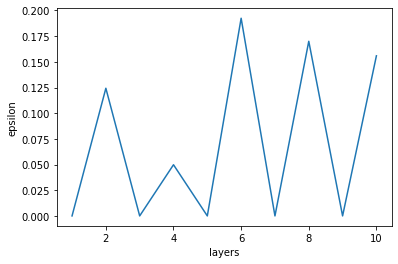

In [108]:
import matplotlib.pyplot as plt

layers = [i+1 for i in range(10)]
plt.plot(layers,epsilons)
plt.xlabel('layers')
plt.ylabel('epsilon')
#plt.savefig('rand_1111ryrz')